In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
 palette = ["#E31A1C", "#1F78B4", "#A6CEE3",  "#B2DF8A", "#33A02C", "#FB9A99",  "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928", "#66C2A5",
               "#FC8D62", "#8DA0CB", "#B3B3B3", "#A6D854", "#FFD92F", "#E5C494", "#E78AC3"]

#### Set up scVI environment

In [3]:
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

In [4]:
import pandas as pd 
import numpy as np

# sPAX8 - Epithelials

### Read in dataset

In [5]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [6]:
adata = sc.read(path_to_gonads + 'FCA-gonads_rawcounts.h5ad')

## Annotate cells

In [7]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/FCA-gonads_female_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

metaM = pd.read_csv(path_to_gonads+'/FCA-gonads_male_annotated.csv')
metaM = metaM.set_index('Unnamed: 0')
metaM.head()


cell_annotM = metaM['lineage'].to_dict()
cell_annotF = metaF['lineage'].to_dict()
cell_annot = {**cell_annotM , **cell_annotF}
adata.obs['lineage'] = adata.obs_names.map(cell_annot).astype('category')

/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
# Add old cluster subname
meta = pd.read_csv(path_to_gonads+'FCA-gonads_somatic_annotated.csv')
meta = meta.set_index('Unnamed: 0')
meta.head()

cell_annot = meta['celltype'].to_dict()
adata.obs['celltype_somatic'] = adata.obs_names.map(cell_annot).astype('category')

/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (29,30,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
adata.obs['lineage'].values.describe()

,counts,freqs
categories,,
CoelEpi,24297,0.061269
Doublet,5821,0.014679
Endothelial,14484,0.036524
Epithelial,20222,0.050993
Erythroid,1371,0.003457
FetalLeydig,2426,0.006118
GermCells,14516,0.036604
Immune,5533,0.013952
Mesenchymal_GATA2,84229,0.212396


In [10]:
adata.obs['celltype_somatic'].values.describe()

,counts,freqs
categories,,
CoelEpi_GATA2,4050,0.010213
CoelEpi_LHX9,5547,0.013988
CoelEpi_LHX9_cycling,1858,0.004685
FetalLeydig,2874,0.007247
Gi,4749,0.011975
OSE,8222,0.020733
Oi,25730,0.064882
Sertoli,36917,0.093092
Ti,34808,0.087774


In [11]:
adata = adata[[ float(i) <= 12 for i in adata.obs.PCW ]]
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.celltype_somatic]]
adata = adata[[i in ['Supporting', 'CoelEpi', 'Epithelial', 'Sertoli'] for i in adata.obs.lineage]]
adata = adata[[i not in ['OSE', 'Oi', 'Ti', 'cont', 'granulosa', 'lowQC', 'preGC_IIa', 'preGC_IIb', 'FetalLeydig'] for i in adata.obs.celltype_somatic]]
adata.X.shape

(60064, 28820)

In [12]:
adata.obs['lineage'].values.describe()

,counts,freqs
categories,,
CoelEpi,12651,0.210625
Epithelial,12288,0.204582
Sertoli,11512,0.191662
Supporting,23613,0.393131


In [13]:
adata.obs['celltype_somatic'].values.describe()

,counts,freqs
categories,,
CoelEpi_GATA2,4014,0.066829
CoelEpi_LHX9,4002,0.066629
CoelEpi_LHX9_cycling,1852,0.030834
Gi,3295,0.054858
Sertoli,12306,0.204881
early_sPAX8,3518,0.058571
early_somatic,1288,0.021444
early_supporting,5854,0.097463
late_sPAX8,974,0.016216


In [14]:
sc.pp.filter_genes(adata, min_counts=5)

Trying to set attribute `.var` of view, copying.
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/anndata/_core/views.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  container[idx] = value


In [15]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 60064
Total number of genes: 24843


### OPTIONAL - Remove cc genes

In [16]:
# ccgs defined in M1
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

Total number of genes after ccg filter: 24728


### Identify HVGs

!!! Unlike before (at least I think), now they recommend subsetting to highly variable genes before running scVI 

--> the tutorial says anywhere in between 1000 and 10,000 should be fine, so I arbitrarily chose 2000

In [17]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3"
)

Trying to set attribute `.uns` of view, copying.


In [18]:
# subset object for scVI
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

## Normalize - optional

In [19]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

## scVI

!!! Here you can specify your covariates you want to correct for

In [20]:
scvi.data.setup_anndata(
    bdata,
    layer="counts",
    batch_key='donor'
#     categorical_covariate_keys=["sample_source"]
#     continuous_covariate_keys=["percent_mito"]#
)

INFO     Using batches from adata.obs["donor"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 60064 cells, 2000 vars, 27        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [21]:
model = scvi.model.SCVI(bdata, n_latent= 40)

In [22]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 40, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [23]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 133/133: 100%|██████████████████████████████████████████████████████████████████████████████████████| 133/133 [13:32<00:00,  6.11s/it, loss=735, v_num=1]


In [24]:
latent = model.get_latent_representation()

In [25]:
adata.obsm["X_scVI"] = latent

### Save latent space

In [35]:
pd.DataFrame(adata.obsm["X_scVI"]).to_csv(path_to_gonads+'/FCA-gonads_XscVI_latent_sPAX8.csv')
pd.DataFrame(adata.obs).to_csv(path_to_gonads+'/FCA-gonads_XscVI_latentMeta_sPAX8.csv')

# X_scVI = pd.read_csv(path_to_gonads+'/FCA-gonads_XscVI_latent_supporting.csv', index_col=0)
# adata.obsm["X_scVI"] = X_scVI.to_numpy()

### Visualization and Clustering

In [27]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3, spread = 1.1)

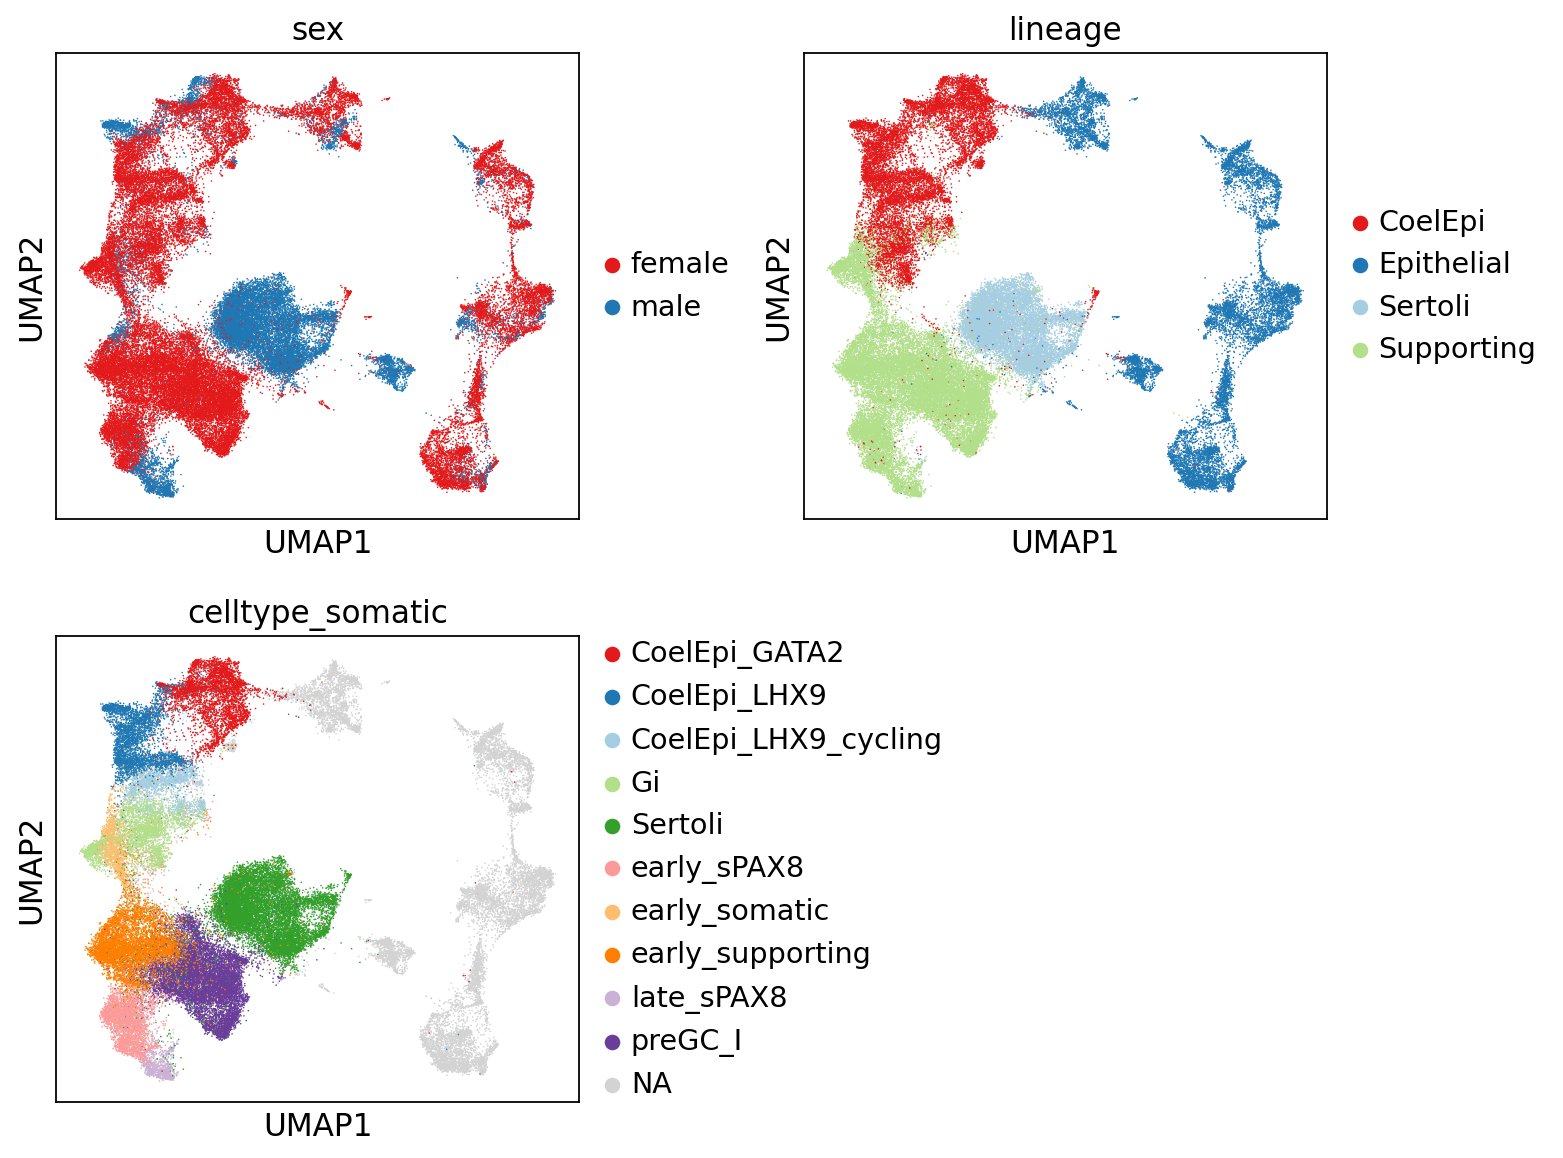

In [28]:
sc.pl.umap(
    adata,
    color=[ 'sex', 'lineage',  "celltype_somatic"], 
    palette = palette,
    frameon=True, ncols = 2, wspace = 0.3
)

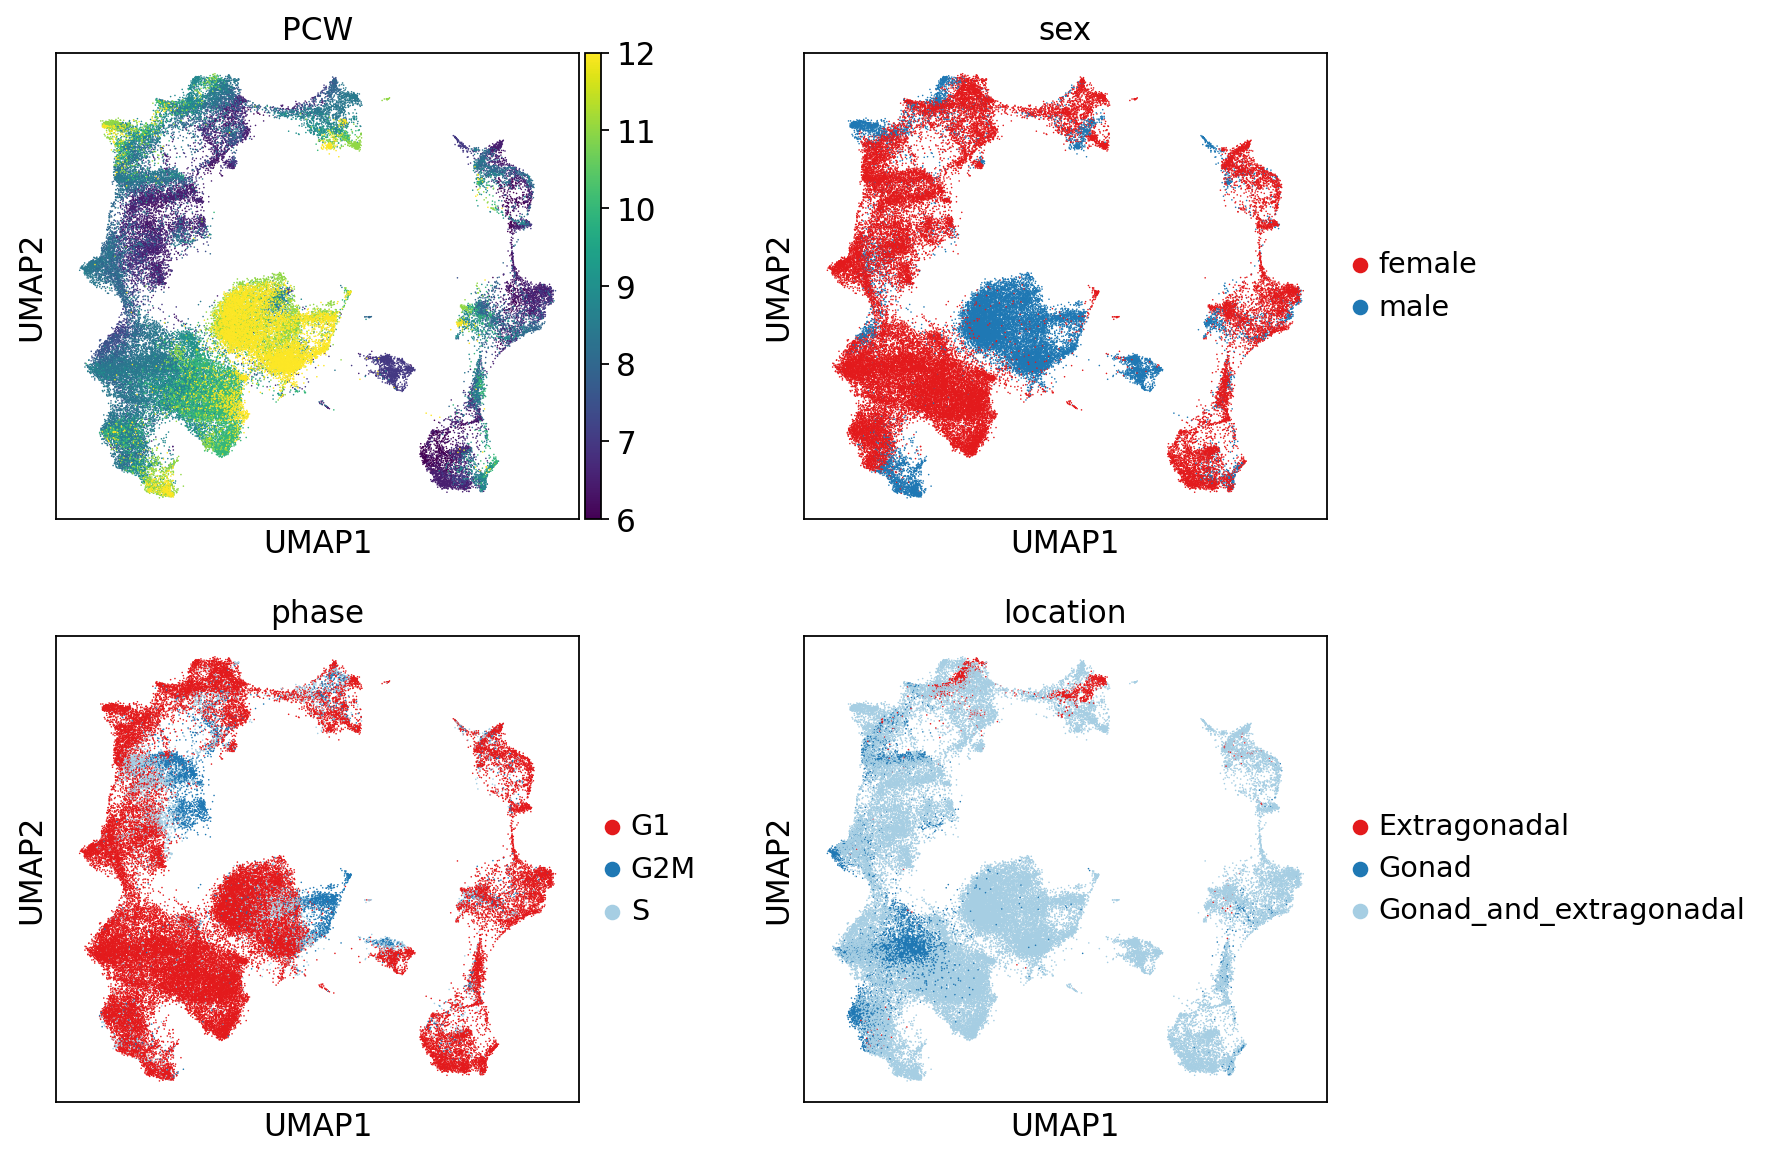

In [29]:
sc.pl.umap(
    adata,
    color=['PCW', "sex", 'phase', 'location'], 
    palette = palette,
    frameon=True, ncols = 2, wspace = 0.3
)

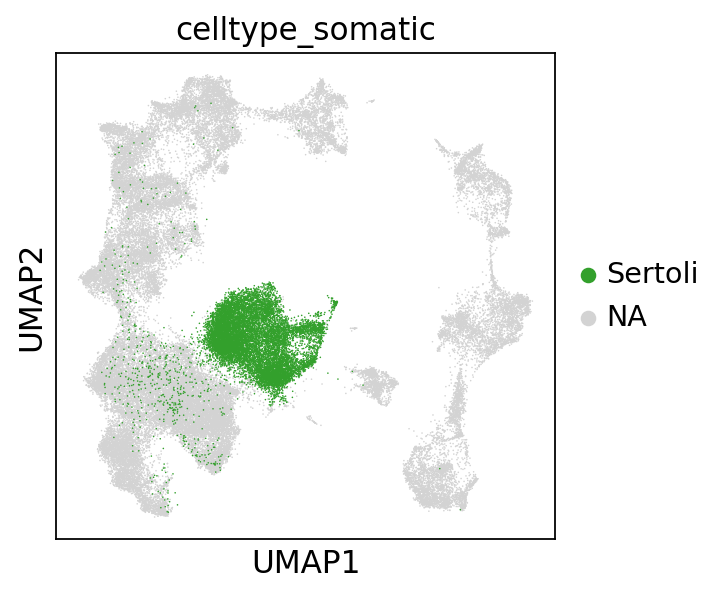

In [30]:
sc.pl.umap(adata, color=['celltype_somatic'], 
           groups = [ 'Sertoli'])

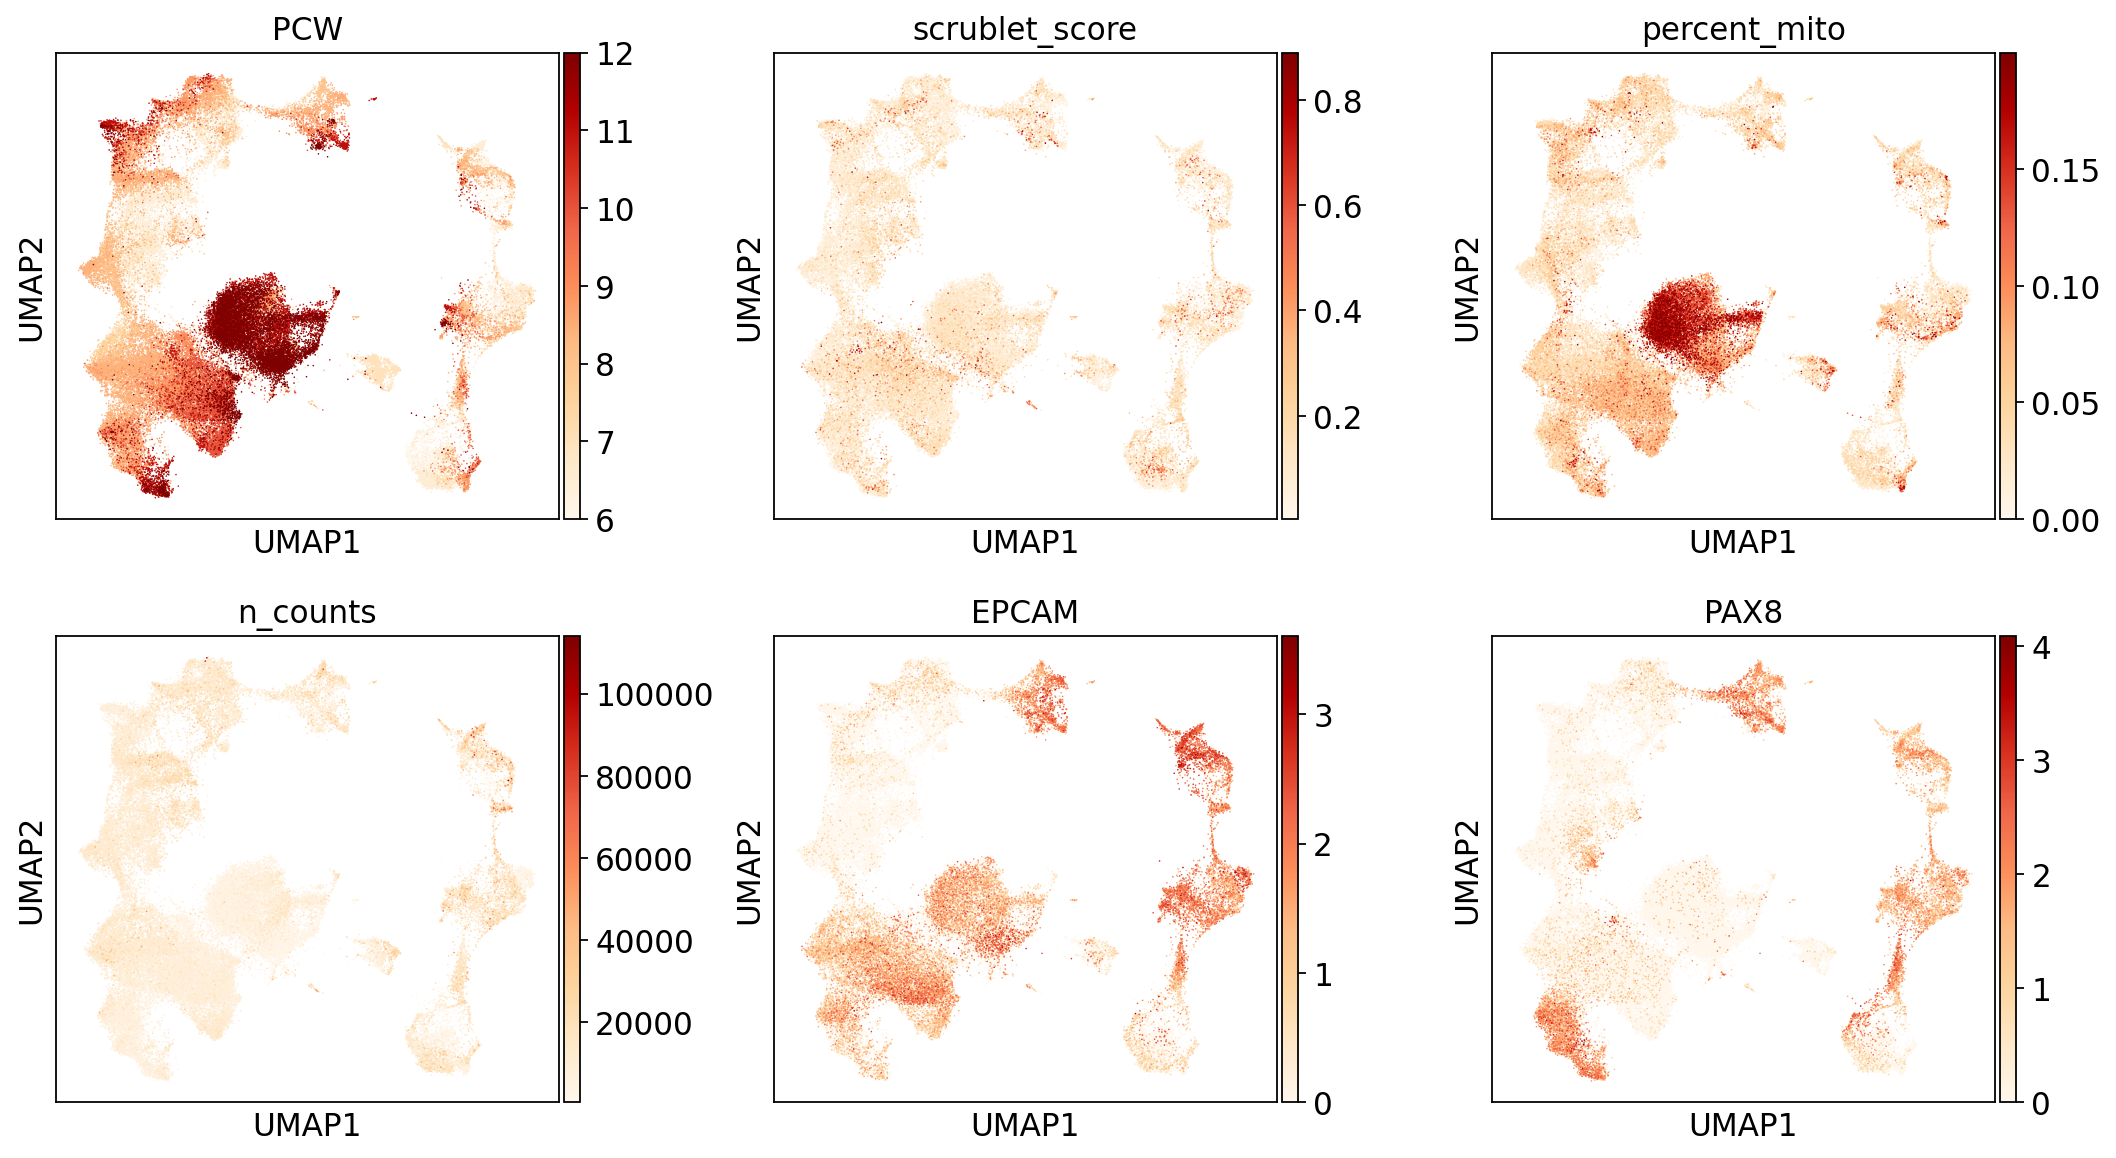

In [31]:
sc.pl.umap(
    adata,
    color=['PCW', 'scrublet_score',  'percent_mito', 'n_counts', 'EPCAM', 'PAX8'], color_map = "OrRd",
    frameon=True, ncols = 3, wspace = 0.3
)

In [32]:
marker_genes = {
    'mesothelial': {'LRRN4', 'UPK3B', 'KLK11'},
    'Gonadal':{'LHX9', 'GATA4', 'ARX'},
    'Supporting':{"WNT6", 'NR5A1'},
    'sKITLG': {'IL17B', 'KITLG', 'VSNL1', 'CDH7' ,'CRB1', 'THSD7A'},
    'sLGR5':{'LGR5', 'TSPAN8', 'SRY', 'EPHA4', 'CXCR4','NANOG',  'RIMS4', 'CCKBR', 'HSD17B14'},
    'granulosa':{'OSR1', 'FOXL2', "IRX3", "RDH10", 'NOTCH3'},
    'OSE':{'LHX2'},
    'Sertoli': {'SOX9', 'INHBB', 'DHH', 'AMH'},
    'sPAX8': {'PAX8'},
    'Stromal':{'DCN', 'PDGFRA', 'TCF21'},
    'Stromal_extra':{'NR2F1', 'GATA2', 'RSPO3'},
#     'Stromal_gond':{'GATA4', 'ARX'},
    'Leydig':{'INSL3', 'HHIP', 'PTCH2', 'FDX1'},
    'PGCs': {'POU5F1', 'NANOS3'},
    'Germ Cells': {'DAZL'},
    'epithelial': {"EPCAM", "KRT19"},
    'neural': {'ASCL1'},
    'endothelial': {'PECAM1', 'CDH5'},
    'immune': {'PTPRC'},
    'erythroid': {"GYPC", "HBA1"},
    'perivascular': {"PDGFRB", 'ACTA2'},
    'erythroid': {"GYPC", "HBA1"}
}
# sc.pl.dotplot(adata, marker_genes, groupby='leiden', standard_scale = 'var')

In [33]:
# adata.obs['celltype'] = adata.obs['leiden'].tolist()
# adata.obs.at[adata.obs['leiden'] == '0', 'celltype'] = 'Sertoli'
# adata.obs.at[adata.obs['leiden'] == '1', 'celltype'] = 'preGC_IIa'
# adata.obs.at[adata.obs['leiden'] == '2', 'celltype'] = 'preGC_I'
# adata.obs.at[adata.obs['leiden'] == '3', 'celltype'] = 'preGC_IIb'
# adata.obs.at[adata.obs['leiden'] == '4', 'celltype'] = 'granulosa'
# adata.obs.at[adata.obs['leiden'] == '5', 'celltype'] = 'Sertoli'
# adata.obs.at[adata.obs['leiden'] == '6', 'celltype'] = 'OSE'
# adata.obs.at[adata.obs['leiden'] == '7', 'celltype'] = 'CoelEpi'
# adata.obs.at[adata.obs['leiden'] == '8', 'celltype'] = 'CoelEpi_GATA2'
# adata.obs.at[adata.obs['leiden'] == '9', 'celltype'] = 'sPAX8e'
# adata.obs.at[adata.obs['leiden'] == '10', 'celltype'] = 'sPAX8m'
# adata.obs.at[adata.obs['leiden'] == '11', 'celltype'] = 'Sertoli'
# adata.obs.at[adata.obs['leiden'] == '12', 'celltype'] = 'sKITLG'
# adata.obs.at[adata.obs['leiden'] == '13', 'celltype'] = 'sLGR5'
# adata.obs.at[adata.obs['leiden'] == '14', 'celltype'] = 'lowQC'
# adata.obs.at[adata.obs['leiden'] == '15', 'celltype'] = 'eSertoli'
# adata.obs.at[adata.obs['leiden'] == '16', 'celltype'] = 'Sertoli'
# set(adata.obs['celltype'])
# sc.pl.umap(adata, color=['celltype'])
# adata.obs['celltype'].cat.reorder_categories(['CoelEpi_GATA2', 'CoelEpi', 'OSE', 
#                                              'sKITLG', 'sLGR5', 'sPAX8e', 'sPAX8m',
#                                               'preGC_I',  'preGC_IIa', 'preGC_IIb','granulosa',
#                                               'eSertoli',   'Sertoli',
#                                                'lowQC'], inplace=True)

# sc.pl.umap(adata, color=['celltype'])
# sc.pl.umap(adata, color=['celltype_v1', 'celltype'], ncols = 2, legend_loc='on data', legend_fontsize=8)